# SpQN RNA-seq co-expression ranking

Purpose: Supplement script to correct for high-expression genes for downstream correlation analysis

#### Table of contents:
<ul>
    <li><a href="#import">Part 0: Import dependencies</a></li>
    <li><a href="#data">Part 1: Import data</a></li>
    <li><a href="#SpQN">Part 2: Perform SpQN normalization</a></li>
    <ul>
        <li>1. Pre-process data</li>
        <li>2. Remove principle components</li>
        <li>3. Perform base correlation of pre-processed data</li>
        <li>4. Re-arrrange the correlation matrix into 10x10 bins and plot</li>
        <li>5. Plot marginal relationship between IQR of correlation and expression level of the lower expression group for each bin</li>
        <li>6. Q-Q plot of original data</li>
        <li>7. SPQN normalization</li>
        <li>8. Re-arrrange the corrected correlation matrix into 10x10 bins and plot</li>
        <li>9. Q-Q plot of corrected data</li>
        <li>10. Plot IQR-expression level relationship of corrected data</li>
    </ul>
    <li><a href="#export">Part 3: Export corrected data</a></li>
    <li><a href="#session">Part 4: Print session info</a></li>
</ul>

<a id="import"><h3>Part 0: Import dependencies</h3></a>

In [1]:
library(spqn)
library(data.table)
library(WGCNA)

library(sva)
library(bladderbatch)
data(bladderdata)
library(pamr)
library(limma)

setwd(
  "C:\\Users\\jorda\\Desktop\\projects\\Metaboverse-manuscript\\mct1_analysis")

Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.0.3"
Loading required package: ggridges

Warning message:
"package 'ggridges' was built under R version 4.0.4"
Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, 

In [2]:
n_comps <- 4

<a id="data"><h3>Part 1: Import data</h3></a>
1. Read data 
2. Previously removed gene rows where min value was not 25 or greater
3. Previously performed TPM normalization of gene counts

In [3]:
# Read data 
# Removed gene rows where min value was not 25 or greater
# Performed TPM normalization of gene counts

exp_name <- "refine_bio_all"
#exp_name <- "refine_bio_wt"


input_file <- paste("data/", exp_name, ".tsv", sep="")
output_file <- paste("data/", exp_name, "_spqn_cor.tsv", sep="")

counts <- read.table(
  input_file, 
  sep="\t", 
  header=TRUE, 
  row.names="X")

<a id="SpQN"><h3>Part 2: Perform SpQN normalization</h3></a>

**1. Pre-process data**

In [4]:
log_data <- log2(counts + 0.5)
ave_log_data <- rowMeans(log_data)
log_data_centered <- log_data - ave_log_data # mean centering
log_data_centered  <- log_data_centered / matrixStats::rowSds(
  as.matrix(log_data_centered)) # variance scaling

**2. Remove principle components**

In [5]:
# Remove PCs (4) from the gene expression matrix after scaling each gene to 
# have mean=0 and variance=1
log_data_pc4 <- removePrincipalComponents(
  t(scale(t(log_data_centered))), 
  n = n_comps)

**3. Perform base correlation of pre-processed data**

In [6]:
cor_m <- cor(t(log_data_pc4))

**4. Re-arrrange the correlation matrix into 10x10 bins and plot**

Picking joint bandwidth of 0.0101

Warning message:
"Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?"
Picking joint bandwidth of 0.0126



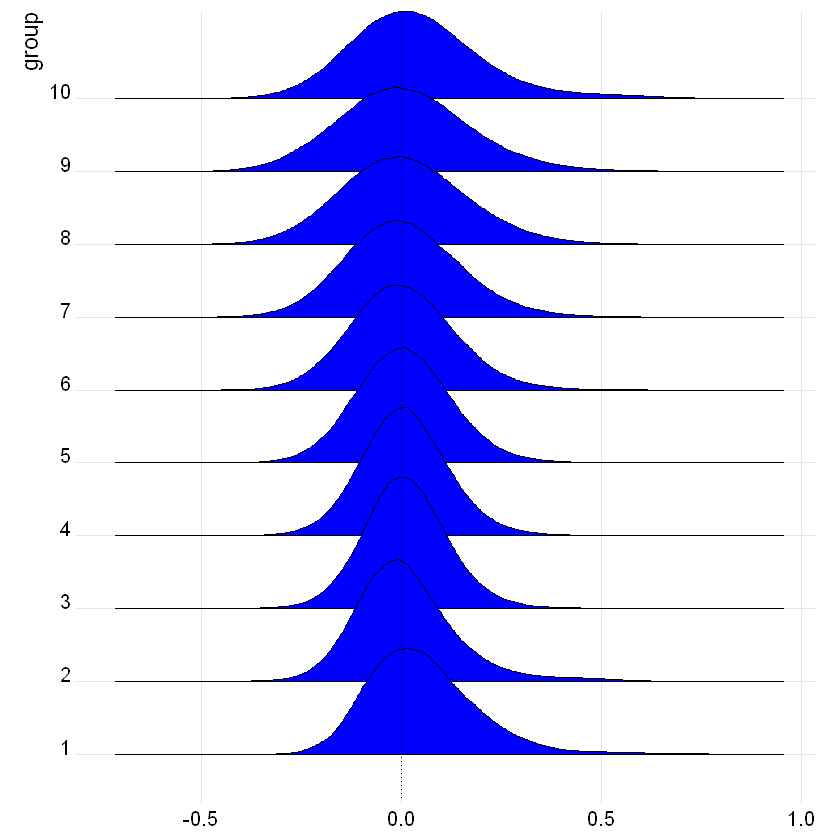

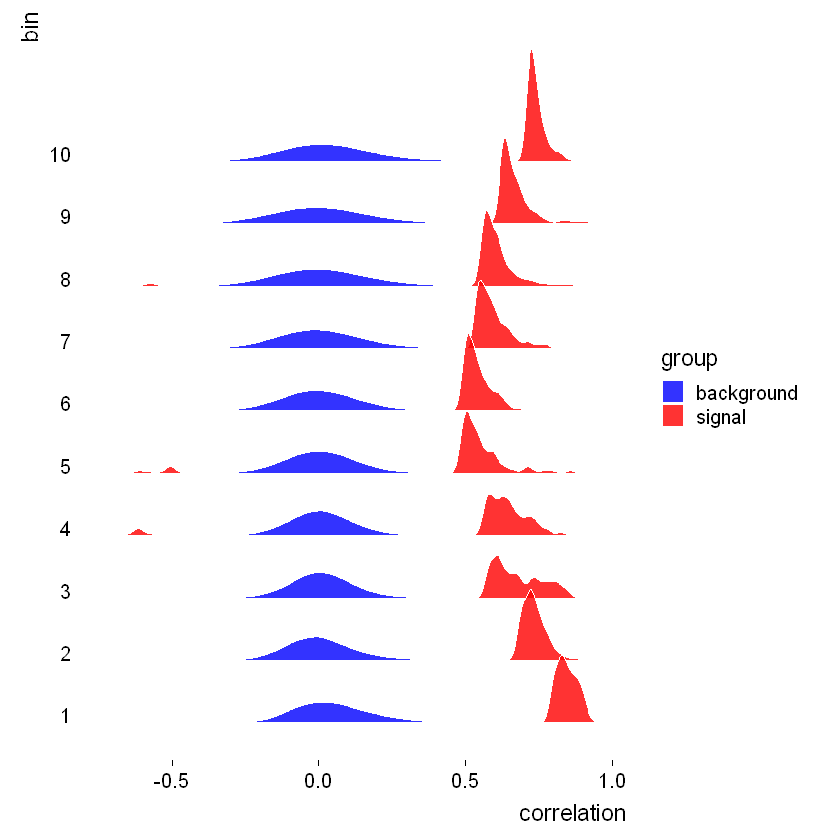

In [7]:
# we re-arrrange the correlation matrix by sortng the row and column by the 
# expression level, and partitioned the correlation matrix into same-size bins, 
# then used each bin to estimate the distribution of correlation for genes with 
# that expression level. Here we use 10 by 10 bins.
# The second plot will show that high-expressed genes' correlation is 
# skewed high
plot_signal_condition_exp(cor_m, ave_log_data, signal=0)
plot_signal_condition_exp(cor_m, ave_log_data, signal=0.001)

**5. Plot marginal relationship between IQR of correlation and expression level of the lower expression group for each bin**

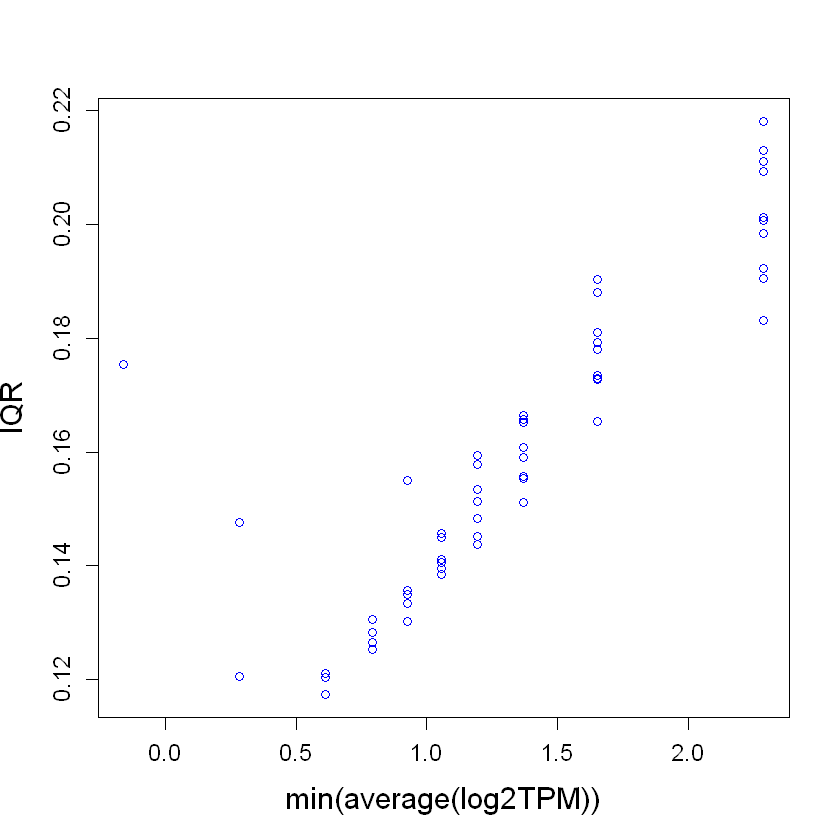

In [8]:
# We next plot the marginal relationship between IQR of correlation and the 
# expression level of the lower expression group for each bin, and we also see 
# a positive relationship.
IQR_list <- get_IQR_condition_exp(cor_m, ave_log_data)
IQR_unlist <- unlist(lapply(1:10, function(ii) IQR_list$IQR_cor_mat[ii, ii:10]))
plot(rep(IQR_list$grp_mean, times = 1:10),
     IQR_unlist,
     xlab="min(average(log2TPM))", ylab="IQR", cex.lab=1.5, cex.axis=1.2, col="blue")

**6. Q-Q plot of original data**

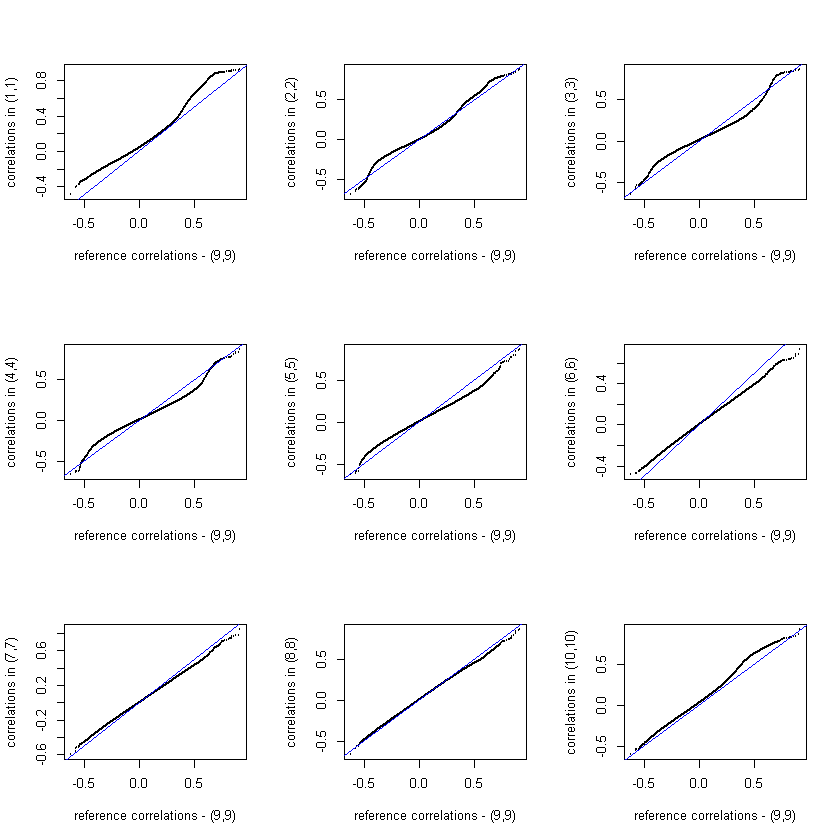

In [9]:
# We further examined the difference of the distributions using Q-Q plot. We 
# used the bins with the second highest expression level on the diagonal as 
# reference, and compared the distribution with other bins in the diagonal. We 
# observe both scale and shape difference in the distributions.
par(mfrow = c(3,3))
for(j in c(1:8,10)){
  qqplot_condition_exp(cor_m, ave_log_data, j, j)
}

**7. SPQN normalization**

In [10]:
cor_m_spqn <- normalize_correlation(
  cor_m, 
  ave_exp=ave_log_data, 
  ngrp=20, 
  size_grp=300, 
  ref_grp=18)

**8. Re-arrrange the corrected correlation matrix into 10x10 bins and plot**

Picking joint bandwidth of 0.012

Warning message:
"Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?"
Picking joint bandwidth of 0.0115



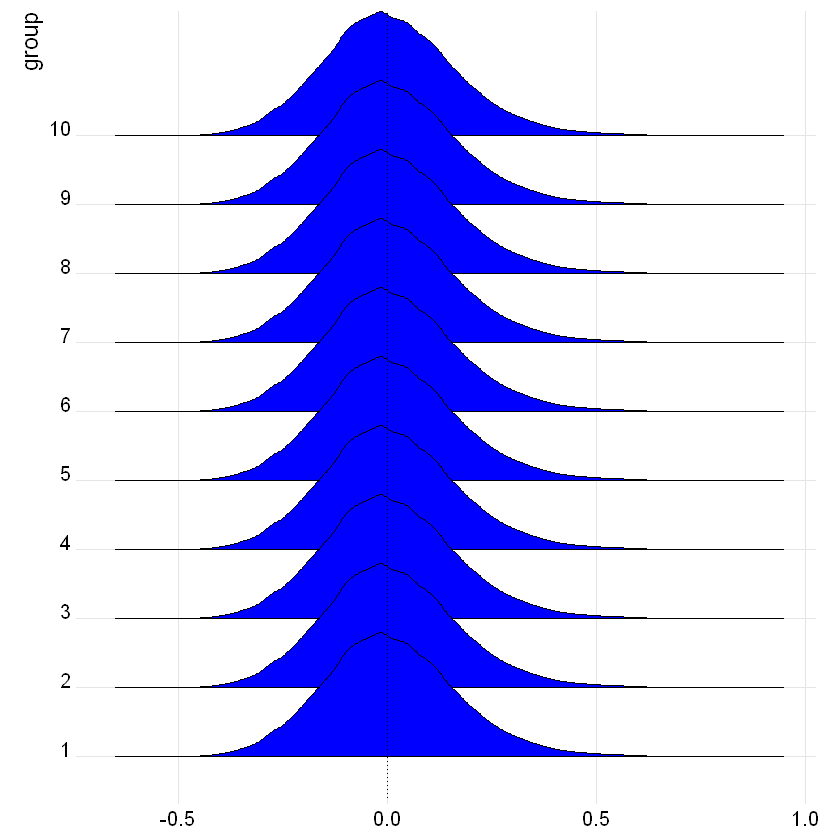

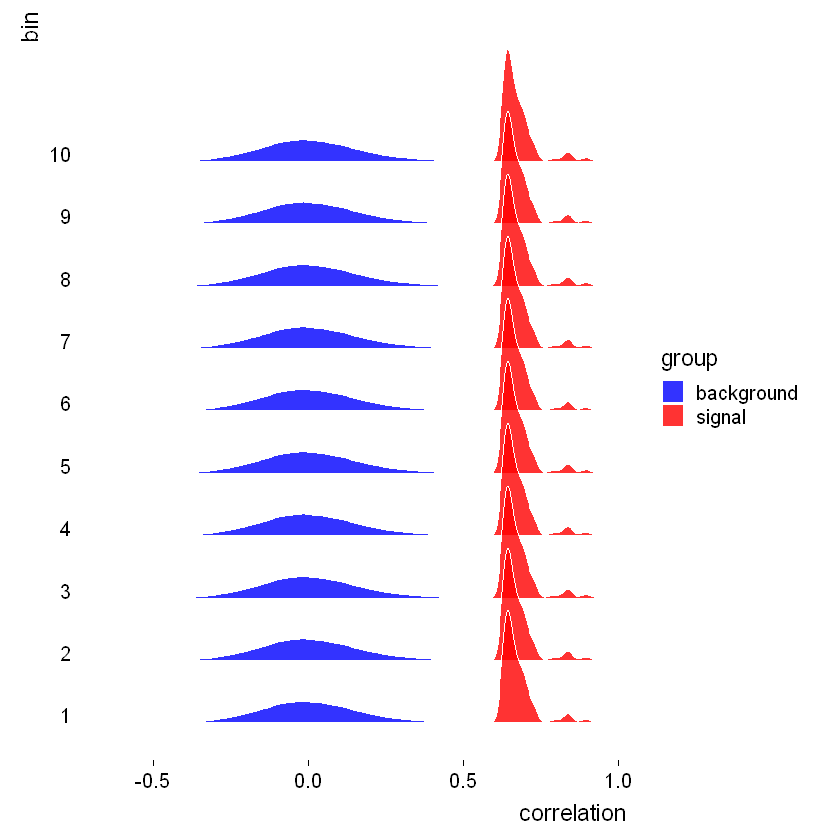

In [11]:
# Distribution of predicted signals and background correlations for bins on the 
# diagonal of the correlation matrix.
# Note: Signal becomes more uniform
plot_signal_condition_exp(cor_m_spqn, ave_log_data, signal=0)
plot_signal_condition_exp(cor_m_spqn, ave_log_data, signal=0.001)

IQR_spqn_list <- get_IQR_condition_exp(cor_m_spqn, ave_log_data)

**9. Q-Q plot of corrected data**

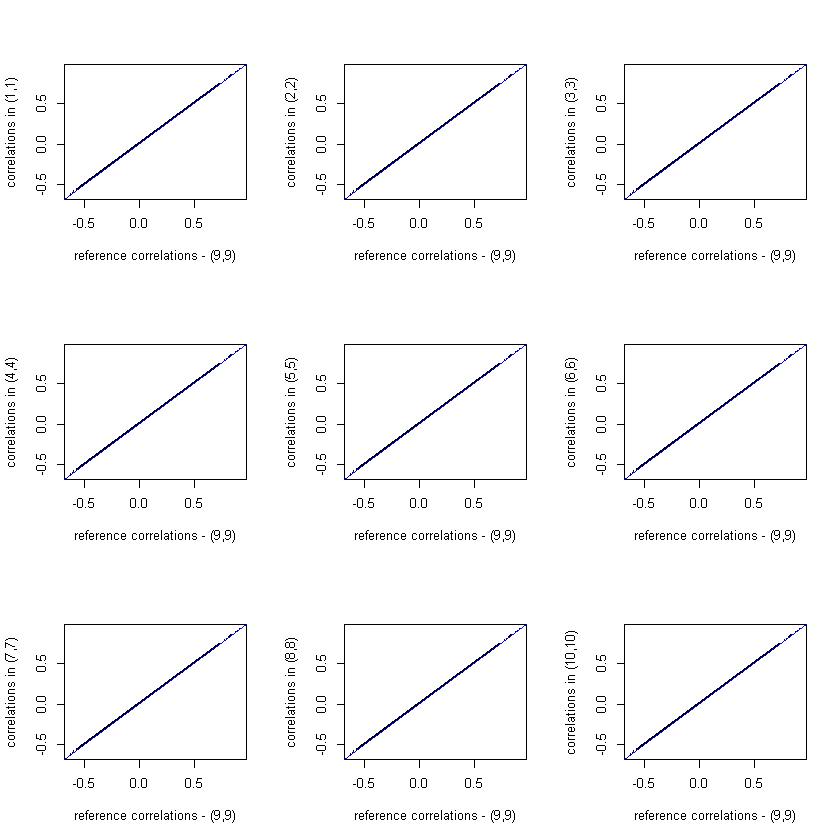

In [12]:
# Q-Q plots
par(mfrow = c(3,3))
for(j in c(1:8,10)){
  qqplot_condition_exp(cor_m_spqn, ave_log_data, j, j)
}

**10. Plot IQR-expression level relationship of corrected data**

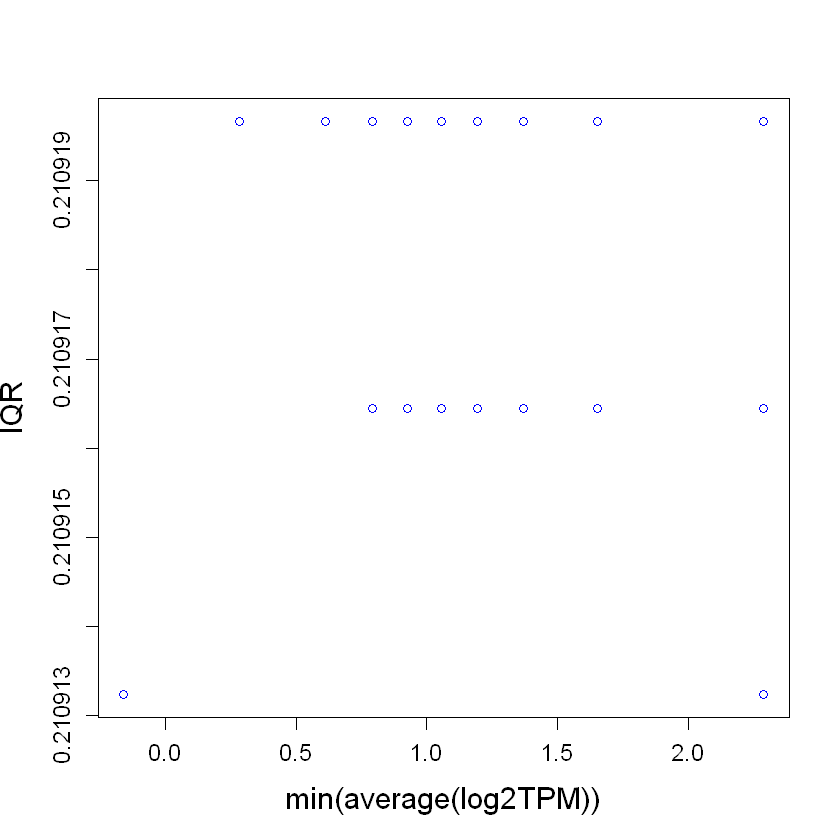

In [13]:
# Marginal relationship between IQR and the expression level of the lower 
# expressed group for each bin.
IQR_unlist <- unlist(lapply(1:10, function(ii) IQR_spqn_list$IQR_cor_mat[ii, ii:10]))
plot(rep(IQR_spqn_list$grp_mean, times = 1:10),
     IQR_unlist,
     xlab="min(average(log2TPM))", ylab="IQR", cex.lab=1.5, cex.axis=1.2, col="blue")

<a id="export"><h3>Part 3: Export corrected data</h3></a>

In [14]:
# Add gene names to row and col names
row.names(cor_m_spqn) <- row.names(cor_m)
colnames(cor_m_spqn) <- colnames(cor_m)

In [15]:
# Output results
write.table(
  cor_m_spqn, 
  file=output_file, 
  row.names=TRUE, 
  col.names=TRUE,
  sep="\t")

<a id="session"><h3>Part 4: Print session info</h3></a>

In [16]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19042)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] limma_3.44.3                pamr_1.56.1                
 [3] survival_3.2-11             cluster_2.1.0              
 [5] bladderbatch_1.26.0         sva_3.36.0                 
 [7] BiocParallel_1.22.0         genefilter_1.70.0          
 [9] mgcv_1.8-31                 nlme_3.1-148               
[11] WGCNA_1.70-3                fastcluster_1.1.25         
[13] dynamicTreeCut_1.63-1       data.table_1.13.6          
[15] spqn_1.0.0                  SummarizedExperiment_1.18.